# SKEKB Beam Beam Test

## Python Setup

In [1]:
import sys

import xobjects as xo
import xtrack as xt
import xfields as xf
import xpart as xp

from xtrack.slicing import Teapot, Strategy

from cpymad.madx import Madx

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

## User Variables

In [2]:
########################################
# Simulation Settings
########################################
n_turns             = int(1E4)
n_macroparticles    = int(1E3)
n_slices            = int(101)
qss_update_freq     = int(1)

########################################
# File Paths
########################################
ler_path            = "/Users/jack/Desktop/*Thesis/Analysis/superkekb/no_sol/sler_1707_80_1_nosol_simple.seq"

########################################
# Computation Mode
########################################
context = xo.ContextCpu(omp_num_threads='auto')

## Machine Parameters

In [3]:
########################################
# HER Parameters
########################################
her_params = {
    'energy':           7.007,
    'p0c':              7.007E9,
    'bunch_intensity':  5.89E10,
    'n_bunches':        2346,
    'beta_x':           60E-3,
    'beta_y':           0.6E-3,
    'physemit_x':       4.59E-9,
    'physemit_y':       2.65E-11,
    'lattemit_y':       1.00E-12, #Guess
    'Qx':               45.532,
    'Qy':               43.573,
    'sigma_delta':      1.00E-3,
    'sigma_z':          6.40E-3,
    'phi':              41.5E-3,
    'circumference':    3016.315,
}

########################################
# LER Parameters
########################################
ler_params = {
    'energy':           4.00,
    'p0c':              4.0E9,
    'bunch_intensity':  7.36E10,
    'n_bunches':        2346,
    'beta_x':           80E-3,
    'beta_y':           0.6E-3,
    'physemit_x':       4.01E-9,
    'physemit_y':       2.65E-11,
    'lattemit_y':       1.00E-12, #Guess
    'Qx':               44.525,
    'Qy':               46.589,
    'sigma_delta':      1.00E-3,
    'sigma_z':          6.50E-3,
    'phi':              -41.5E-3,
    'circumference':    3016.315,
}

########################################
# Constants
########################################
mass0               = xp.ELECTRON_MASS_EV

## Load LER

In [4]:
mad = Madx(
    stdout=sys.stdout # Needs to be set to sys.stdout or breaks
)
print("MADX Spawned")
mad.input(
f"""
    SET, FORMAT="19.15f";
    !option, echo;
    option, update_from_parent=true; // new option in mad-x as of 2/2019

    BEAM, PARTICLE=POSITRON, ENERGY={ler_params['energy']};

    CALL, FILE="{ler_path}";

    USE, SEQUENCE=ASC;
    
    SXT_ON = 1;
    RF_ON =1;
        
    USE,SEQUENCE=ASC;
        TWISS;

"""
)
ler = xt.Line.from_madx_sequence(
        mad.sequence['ASC'],
        allow_thick=True,
        deferred_expressions=True,
    )
print("Line Built from MADX Sequence")


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.09.01  (64 bit, Darwin)      +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2023.12.04               +
  + Execution date: 2024.05.10 16:36:14      +
  ++++++++++++++++++++++++++++++++++++++++++++
MADX Spawned
!

!SAD2MADX V0.4.1 (11/5/2018)

!Conversion of seq_ler at Sat Apr 27 10:13:23 CEST 2024

!

AXISAD =-2.3105151911690732e-11; BXISAD =.08000000000342304; AYISAD =-9.234472148971401e-11; BYISAD =.0010000000000005705; EXISAD =2.802972170610218e-13; EPXISAD =2.262517074610412e-13; EYISAD =2.650075255569153e-17; EPYISAD =-9.846063661244911e-16;

K1QC1LP = -5.064472726622586;

LQC1LP = .34;

K1QC2LP = 2.1009027988160134;

LQC2LP = .41;

LQKALP = .3444;

ANGLEBLC1LP1 = -.02478873839787652;

LBLC1LP1 = 1.6031209539205753;

ANGLEBLC1LP2 = -.009702723135905122;

LBLC1LP2 = 2.2353772314445624;

LQKBLP = .3444;

LZDS1LP = .25;

K1QLC1LP = -.29843291935174393;

LQLC1LP = .58372;

LQKCLP = .3444;

LZDS2LP = 

Converting sequence "asc":   0%|          | 0/2629 [00:00<?, ?it/s]

Line Built from MADX Sequence


In [5]:
tt = ler.get_table()
tt.rows[:10].show()

name             s element_type isthick isreplica parent_name iscollective
asc$start        0 Marker         False     False        None        False
ip.1             0 Marker         False     False        None        False
drift_0          0 Drift           True     False        None        False
qc1lp.1      0.765 Quadrupole      True     False        None        False
drift_1      1.105 Drift           True     False        None        False
qc2lp.1       1.72 Quadrupole      True     False        None        False
drift_2       2.13 Drift           True     False        None        False
qkalp.1    4.62907 Quadrupole      True     False        None        False
drift_3    4.97347 Drift           True     False        None        False
blc1lp1.1  5.48656 Bend            True     False        None        False


## Slicing

In [6]:
# define strategy for elements and perform slicing
slicing_strategies = [
    Strategy(slicing=Teapot(1)),  # Default catch-all as in MAD-X
    Strategy(slicing=Teapot(4), element_type=xt.Bend),
    Strategy(slicing=Teapot(5), element_type=xt.Quadrupole),
    Strategy(slicing=Teapot(4), element_type=xt.Sextupole),
]

ler.discard_tracker()
print("Slicing thick elements...")
ler.slice_thick_elements(slicing_strategies)

Slicing thick elements...


Slicing line:   0%|          | 0/2629 [00:00<?, ?it/s]

## Build Reference Particles

In [7]:
ler_ref_particle = xp.Particles(
    mass0   = xp.ELECTRON_MASS_EV,
    q0      = 1,
    p0c     = ler_params['p0c']
    )
ler.particle_ref = ler_ref_particle

ler.build_tracker()
ler.config.XTRACK_USE_EXACT_DRIFTS = True

Found suitable prebuilt kernel `default_only_xtrack`.


## Correct RF Issue

In [8]:
ler_table = ler.get_table()
tt_cav = ler_table.rows[ler_table.element_type=='Cavity']

for nn in tt_cav.name:
    ler.element_refs[nn].lag = 180

## Twiss in XSuite

In [9]:
ler_tw_4d = ler.twiss(eneloss_and_damping=False, method="4d")
print(f"LER: {(ler_tw_4d.qx, ler_tw_4d.qy)}")

Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
LER: (44.61091643171956, 46.248745180309996)


## Configure Radiation

In [10]:
ler.configure_radiation(model='mean')
ler.compensate_radiation_energy_loss()

Compensating energy loss.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Share energy loss among cavities (repeat until energy loss is zero)
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Energy loss: 376761.869 eV             
Energy loss: 63.033 eV             
Energy loss: 0.011 eV             

  - Set delta_taper
  - Restore cavity voltage and frequency. Set cavity lag


## Twiss

In [11]:
ler_tw_rad = ler.twiss(eneloss_and_damping=True, method="6d")
print(f"LER: {(ler_tw_rad['eq_gemitt_x'], ler_tw_rad['eq_gemitt_y'])}")

Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
LER: (5.696751003226023e-09, 5.198292435005103e-13)


(0.08, 0.0006)
(0.07074241907486278, 0.0012068272261438803)


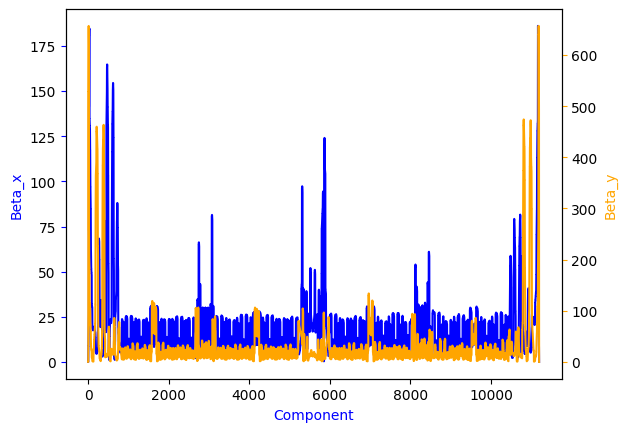

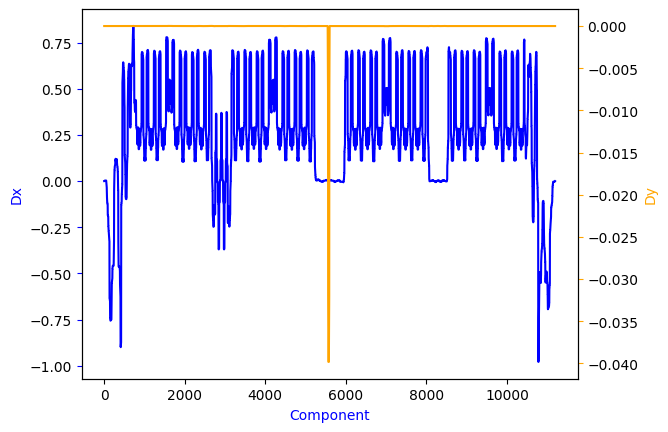

In [12]:
print((ler_params['beta_x'], ler_params['beta_y']))
print((min(ler_tw_rad['betx']), min(ler_tw_rad['bety'])))

fig, ax1 = plt.subplots()

ax1.set_xlabel('Component', c='b')
ax1.set_ylabel('Beta_x', c='b')
ax1.plot(ler_tw_rad['betx'], c='b')
ax1.tick_params(axis='y', color='b')

ax2 = ax1.twinx()
ax2.set_ylabel('Beta_y', c='orange')
ax2.plot(ler_tw_rad['bety'], c='orange')
ax2.tick_params(axis='y', color='orange')

plt.show()

fig, ax1 = plt.subplots()

ax1.set_xlabel('Component', c='b')
ax1.set_ylabel('Dx', c='b')
ax1.plot(ler_tw_rad['dx'], c='b')
ax1.tick_params(axis='y', color='b')

ax2 = ax1.twinx()
ax2.set_ylabel('Dy', c='orange')
ax2.plot(ler_tw_rad['dy'], c='orange')
ax2.tick_params(axis='y', color='orange')

plt.show()

## Twiss with BB and offsets

In [13]:
ttsext = tt.rows[tt.element_type=='Sextupole']

In [14]:
def reset_sextupoles():
    for sextupole in ttsext.name:
        ler.element_refs[sextupole].shift_x = 0
        ler.element_refs[sextupole].shift_y = 0
        ler.element_refs[sextupole].rot_s_rad = 0

In [15]:
offset_repeats  = 20
offsets         = np.logspace(-6, -4, 21)
emit_y_means    = []
emit_y_stds     = []
ln_emit_y_means    = []
ln_emit_y_stds     = []

for offset in tqdm(offsets):
    offset_emit_ys = []
    offset_ln_emit_ys = []
    for i in range(offset_repeats):
        reset_sextupoles()
        for sextupole in ttsext.name:
            ler.element_refs[sextupole].shift_y = np.random.normal(0, offset)

        try:
            ler_tw_offset = ler.twiss(eneloss_and_damping=True, method="6d")
            offset_emit_ys.append(ler_tw_offset['eq_gemitt_y'])
            offset_ln_emit_ys.append(np.log(ler_tw_offset['eq_gemitt_y']))
        except:
            offset_emit_ys.append(np.nan)
            offset_ln_emit_ys.append(np.nan)
    emit_y_means.append(np.nanmean(offset_emit_ys))
    emit_y_stds.append(np.nanstd(offset_emit_ys))
    ln_emit_y_means.append(np.nanmean(offset_ln_emit_ys))
    ln_emit_y_stds.append(np.nanstd(offset_ln_emit_ys))

100%|██████████| 21/21 [02:11<00:00,  6.26s/it]


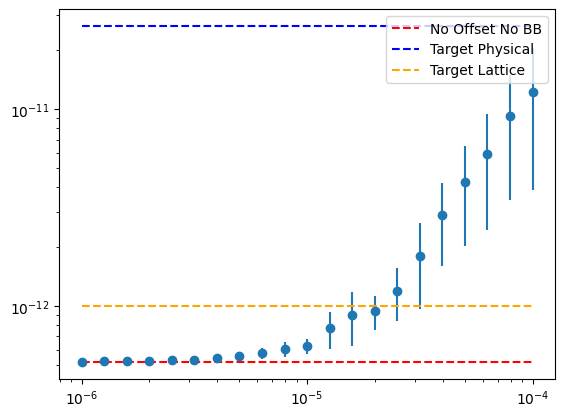

In [16]:
plt.errorbar(offsets, emit_y_means, yerr=emit_y_stds, fmt='o')
plt.hlines(ler_tw_rad['eq_gemitt_y'], offsets[0], offsets[-1], linestyles='dashed', colors='r', label='No Offset No BB')
plt.hlines(ler_params['physemit_y'], offsets[0], offsets[-1], linestyles='dashed', colors='b', label='Target Physical')
plt.hlines(ler_params['lattemit_y'], offsets[0], offsets[-1], linestyles='dashed', colors='orange', label='Target Lattice')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

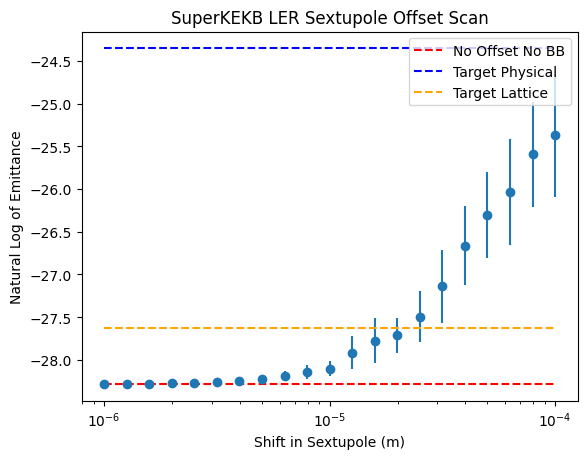

In [19]:
plt.errorbar(offsets, ln_emit_y_means, yerr=ln_emit_y_stds, fmt='o')
plt.hlines(np.log(ler_tw_rad['eq_gemitt_y']), offsets[0], offsets[-1], linestyles='dashed', colors='r', label='No Offset No BB')
plt.hlines(np.log(ler_params['physemit_y']), offsets[0], offsets[-1], linestyles='dashed', colors='b', label='Target Physical')
plt.hlines(np.log(ler_params['lattemit_y']), offsets[0], offsets[-1], linestyles='dashed', colors='orange', label='Target Lattice')
plt.xscale('log')
plt.title('SuperKEKB LER Sextupole Offset Scan')
plt.xlabel('Shift in Sextupole (m)')
plt.ylabel('Natural Log of Emittance')
plt.legend()
plt.show()